# ЛР: Прямое и обратное преобразование Радона

## Цель работы
Изучить преобразование Радона, его связь с преобразованием Фурье, а также реализовать прямое и обратное преобразование Радона в среде Python. Исследовать влияние шага углового сканирования на качество восстановления изображения.

---

## Теория

### Преобразование Радона
Преобразование Радона — это интегральное преобразование, которое сопоставляет функции, заданной на плоскости, набор её интегралов вдоль прямых. В задачах обработки изображений оно моделирует процесс получения проекций объекта при различных углах.

Совокупность проекций при разных углах образует синограмму. Преобразование Радона широко применяется в задачах компьютерной томографии и обратных задач.


### Обратное преобразование Радона
Восстановление изображения по проекциям осуществляется с помощью алгоритма фильтрованной обратной проекции (Filtered Backprojection, FBP).

Алгоритм включает следующие этапы:
1. Вычисление одномерного преобразования Фурье для каждой проекции.
2. Применение частотного фильтра, усиливающего высокие частоты.
3. Выполнение обратного одномерного преобразования Фурье.
4. Суммирование отфильтрованных проекций вдоль соответствующих направлений.

Данный метод реализован в библиотеке `scikit-image` в функции `iradon`.


## Практика в Python (scikit-image)


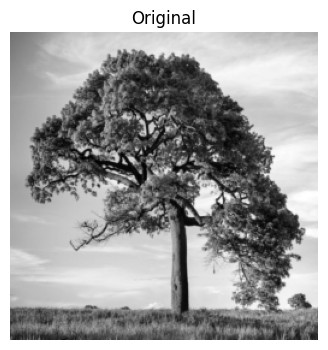

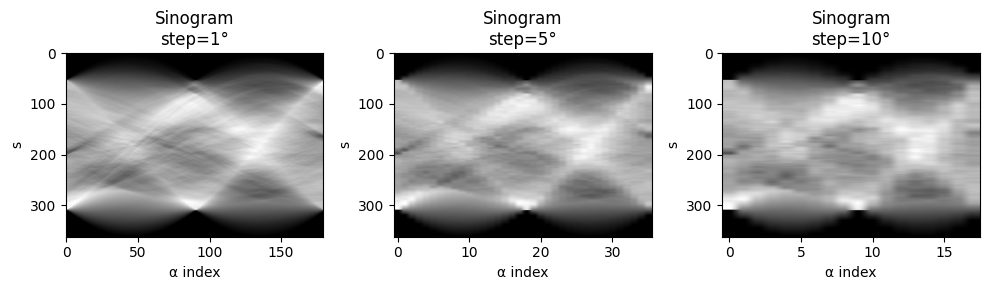

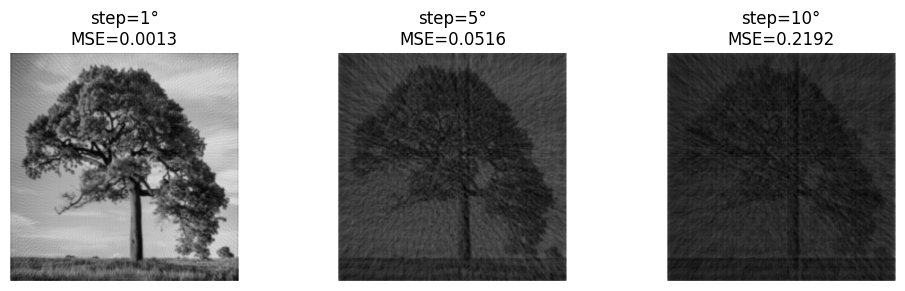

Шаг сканирования (°)	Число проекций	Среднеквадратичная ошибка (MSE)
1			180		0.001293
5			36		0.051647
10			18		0.219233


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.transform import radon, iradon, resize
from skimage.metrics import mean_squared_error

img_path = 'source.png'  # файл лежит рядом с ноутбуком

# 1–2) Загрузка, Ч/Б, нормализация
img = io.imread(img_path)

# Если RGBA — отбросить alpha-канал
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]

# Перевод в grayscale
if img.ndim == 3:
    img = color.rgb2gray(img)

img = img_as_float(img)

# Приведение к квадрату 256x256
N = 256
img = resize(img, (N, N), anti_aliasing=True)
img = np.clip(img, 0.0, 1.0)

steps = [1, 5, 10]
results = {}

for step in steps:
    theta = np.arange(0, 180, step)
    sinogram = radon(img, theta=theta, circle=False)
    recon = iradon(sinogram, theta=theta, circle=False, filter_name='ramp')

    mse = mean_squared_error(img, recon)

    results[step] = dict(
        theta=theta,
        sinogram=sinogram,
        recon=recon,
        mse=mse
    )

# --- Визуализация ---
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, step in enumerate(steps, 1):
    plt.subplot(1, 3, i)
    plt.imshow(results[step]['sinogram'], cmap='gray', aspect='auto')
    plt.title(f'Sinogram\nstep={step}°')
    plt.xlabel('α index')
    plt.ylabel('s')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
for i, step in enumerate(steps, 1):
    plt.subplot(1, 3, i)
    r = results[step]   
    plt.imshow(r["recon"], cmap='gray')
    plt.title(f'step={step}°\nMSE={r["mse"]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

print('Шаг сканирования (°)\tЧисло проекций\tСреднеквадратичная ошибка (MSE)')
for step in steps:
    r = results[step]
    print(f"{step}\t\t\t{len(r['theta'])}\t\t{r['mse']:.6f}")
